In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

import torch

# need to import classes in order for torch.load to work
from latent_geometry.model.mnist_vae import (
    load_decoder,
    load_encoder,
    EncoderVAE,
    DecoderVAE,
)
from latent_geometry.mapping import TorchModelMapping
from latent_geometry.visual.plotly import (
    create_topology_fig,
)
from latent_geometry.manifold import LatentManifold
from latent_geometry.metric import EuclideanMetric
from latent_geometry.path import ManifoldPath
from latent_geometry.data import load_mnist_dataset
from latent_geometry.utils import project
import os

In [3]:
# raise Exception("double check that we wont use already taken gpu ($ nvidia-smi)")
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
dataset = load_mnist_dataset(split="test")
img, label = dataset[0]
print(img.shape, label)

torch.Size([1, 32, 32]) 7


In [5]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
DEVICE = torch.device("cuda")

ENCODER = load_encoder(DEVICE)
DECODER = load_decoder(DEVICE)

z, mu, log_var = ENCODER(dataset[0][0].to(DEVICE)[None, :])
reconstruction = DECODER(z)
reconstruction.shape

torch.Size([1, 1, 32, 32])

In [6]:
SOLVER_TOL = 0.1

In [7]:
ambient_metric = EuclideanMetric(1024)
latent_mapping = TorchModelMapping(DECODER, (2,), (1, 32, 32), batch_size=10_000)
manifold_mnist = LatentManifold(
    latent_mapping, ambient_metric, solver_tol=SOLVER_TOL, bvp_n_mesh_nodes=1_000
)

In [8]:
def create_straight_path(
    from_: np.ndarray, to_: np.ndarray, manifold: LatentManifold
) -> ManifoldPath:
    def x_fun(t: float) -> np.ndarray:
        return from_ + (to_ - from_) * t

    def v_fun(t: float) -> np.ndarray:
        return from_ - to_

    return ManifoldPath(
        x_fun, v_fun, manifold.metric, manifold._euclidean_latent_metric
    )


def create_latent_path(from_: np.ndarray, theta: float, length: float) -> ManifoldPath:
    return manifold_mnist.path_given_direction(
        from_, np.array([np.cos(theta), np.sin(theta)]), length
    )


def create_geodesic_path(from_: np.ndarray, to_: np.ndarray) -> ManifoldPath:
    return manifold_mnist.geodesic(from_, to_)

In [17]:
def show_path_in_ambient(path: ManifoldPath, n_points: int = 9):
    fig, axes = plt.subplots(1, n_points, figsize=(1.5 * n_points, 2))
    for i in range(n_points):
        t = i / (n_points - 1)
        latent_dist = path.manifold_length(0, t)
        euclidean_dist = path.euclidean_length(0, t)
        image = project(latent_mapping)(path(t)).reshape((32, 32))
        ax = axes[i]
        ax.imshow(image, cmap="gray")
        ax.set_title(f"Euc: {euclidean_dist:.3f}, P-B: {latent_dist: .3f}", fontsize=8)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

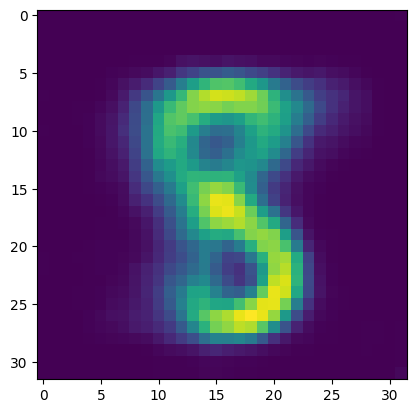

In [10]:
START = np.array([0.0, 0.5])
plt.imshow(project(latent_mapping)(START).reshape(32, 32))

In [11]:
latent_path = create_latent_path(START, np.pi * 0.9, 10.0)
straight_path = create_straight_path(latent_path(0), latent_path(1), manifold_mnist)

In [26]:
straight_path(0), straight_path(1)
# latent_path(0), latent_path(1)
# geodesic(0), geodesic(1)

(array([0. , 0.5]), array([-0.36238486,  0.70184807]))

In [13]:
geodesic = create_geodesic_path(latent_path(0), latent_path(1))

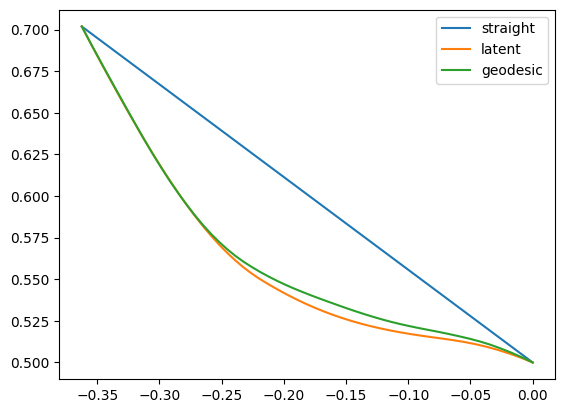

In [39]:
TS = np.linspace(0, 1)
straight_pts = np.array([straight_path(t) for t in TS])
latent_pts = np.array([latent_path(t) for t in TS])
geodesic_pts = np.array([geodesic(t) for t in TS])

plt.plot(straight_pts[:, 0], straight_pts[:, 1], label="straight")
plt.plot(latent_pts[:, 0], latent_pts[:, 1], label="latent")
plt.plot(geodesic_pts[:, 0], geodesic_pts[:, 1], label="geodesic")

plt.legend()
plt.show()

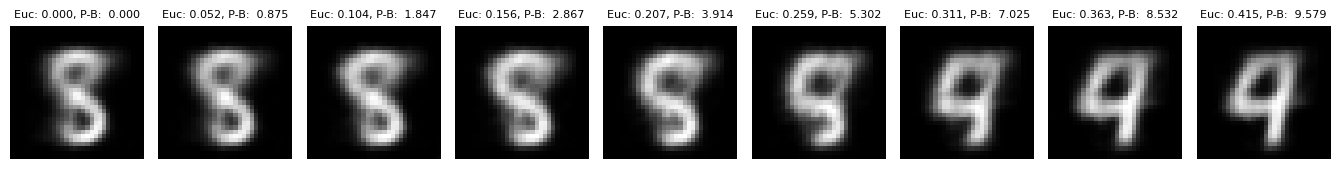

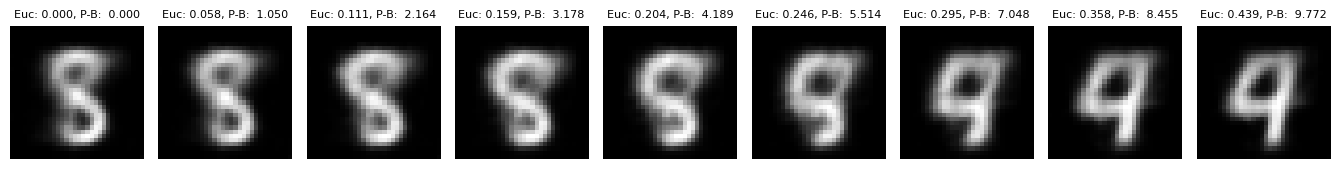

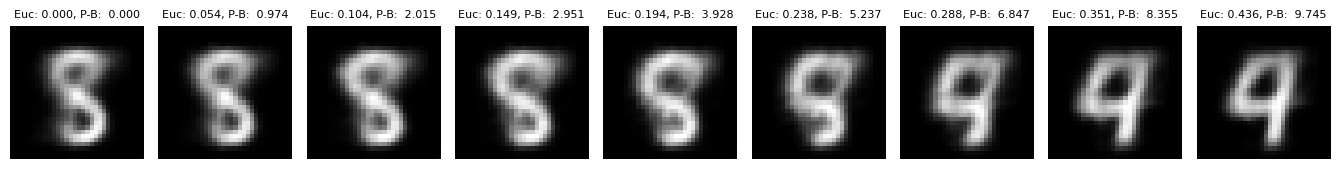

In [18]:
show_path_in_ambient(straight_path, n_points=9)
show_path_in_ambient(latent_path, n_points=9)
show_path_in_ambient(geodesic, n_points=9)